In [ ]:
import pandas as pd
from collections import Counter
import os
from tqdm import tqdm

# Folder paths
scenery_folder = '../../data/processed/landscape_type'
ratings_folder = '../../data/processed/landscape_score'

# Define score bins
bins = [1, 2, 3, 4, 5, 6, 7]
labels = [1, 2, 3, 4, 5, 6]

# Initialize a dictionary to count scenery types for each score bin
scenery_counts_by_bin = {label: Counter() for label in labels}

# Get file lists
ratings_files = [f for f in os.listdir(ratings_folder) if f.startswith("processed_ns6_clean_") and f.endswith(".csv")]
scenery_files = [f.replace("processed_", "") for f in ratings_files]

try:
    # Process files
    for ratings_file, scenery_file in tqdm(zip(ratings_files, scenery_files), total=len(ratings_files), desc="Processing Files"):
        # Read ratings and scenery files
        ratings_data = pd.read_csv(os.path.join(ratings_folder, ratings_file))
        scenery_data = pd.read_csv(os.path.join(scenery_folder, scenery_file))
        
        # Bin the score data
        ratings_data['score_bin'] = pd.cut(ratings_data['predicted_score'], bins=bins, labels=labels, right=False)
        
        # Set index in the scenery file to speed up lookup
        scenery_data.set_index('filename', inplace=True)
        
        # Iterate through the rows of the ratings data
        for idx, row in ratings_data.iterrows():
            score_bin = row['score_bin']
            image_path = row['image_path']
            
            try:
                # Retrieve scenery types based on image path
                scenery_row = scenery_data.loc[image_path]
                
                # Count all 5 scenery types for this image
                for col in [0, 2, 4, 6, 8]:
                    scenery_type = scenery_row[col]
                    scenery_counts_by_bin[score_bin][scenery_type] += 1
            except KeyError:
                # If the image path does not exist in the scenery data, skip it
                print(f"Warning: Image path '{image_path}' not found in scenery file '{scenery_file}'.")
            except Exception as e:
                # Catch any other potential exceptions
                print(f"Error processing image '{image_path}' in file '{ratings_file}': {e}")
        

    # Save the top twenty scenery types and their proportions
    output_data = []

    for score_bin, counts in scenery_counts_by_bin.items():
        total_count = sum(counts.values())
        top_twenty = counts.most_common(20)
        for scenery_type, count in top_twenty:
            proportion = count / total_count  # Calculate proportion
            output_data.append({
                'score_bin': score_bin,
                'scenery_type': scenery_type,
                'count': count,
                'proportion': proportion
            })

    # Convert to DataFrame and save as CSV
    output_df = pd.DataFrame(output_data)
    output_df.to_csv("top_twenty_scenery_types_by_score_bin.csv", index=False)

    print("Results saved to 'top_twenty_scenery_types_by_score_bin.csv'")

except Exception as e:
    print(f"An error occurred during processing: {e}")


/tmp/ipykernel_650655/1485764716.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_df = df.groupby('score_bin').apply(lambda x: x.nlargest(5, 'proportion')).reset_index(drop=True)


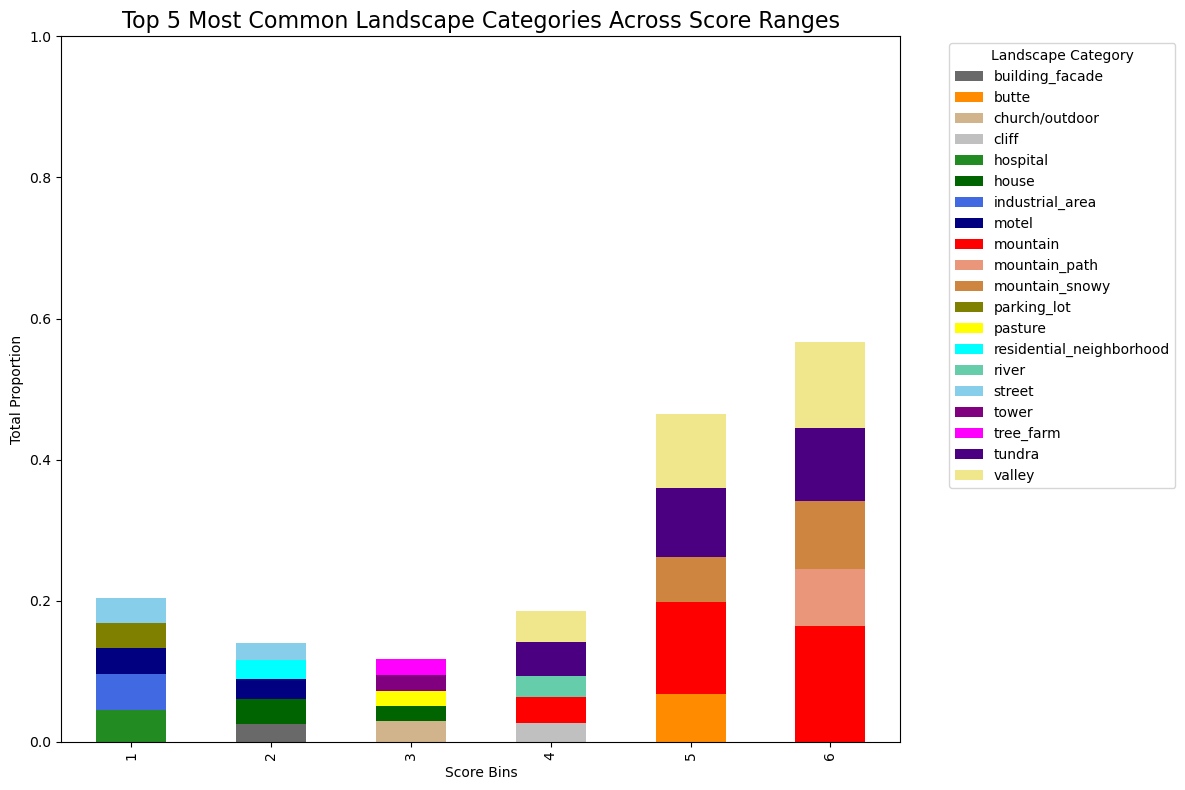

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define high contrast colors
colorBoard = [
    "dimgray", "darkorange", "tan", "silver", "forestgreen",
    "darkgreen", "royalblue", "navy", "red", "darksalmon", "peru", "olive",
    "yellow", "cyan", "mediumaquamarine", "skyblue", "purple", "fuchsia",
    "indigo", "khaki"
]

# Convert color names to hex format
high_contrast_colors = [mcolors.to_hex(color) for color in colorBoard]

# Read the generated CSV file
df = pd.read_csv("top_twenty_scenery_types_by_score_bin.csv")

# Filter to keep only the top 5 categories for each score bin
top_5_df = df.groupby('score_bin').apply(lambda x: x.nlargest(5, 'proportion')).reset_index(drop=True)

# Pivot the data for plotting
pivot_df = top_5_df.pivot(index='score_bin', columns='scenery_type', values='proportion').fillna(0)

# Plot each score bin with top 5 landscape categories

ax = pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8), color=high_contrast_colors)

ax.set_ylim(0, 1)

# Customize plot appearance
plt.title('Top 5 Most Common Landscape Categories Across Score Ranges', fontsize=16)
plt.xlabel('Score Bins')
plt.ylabel('Total Proportion')
plt.legend(title='Landscape Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show or save the plot
plt.savefig("/home/ubuntu/landscape-aesthetics/reports/figures/top_five_landscape_categories_by_score_bin_wikidata.jpg")
plt.show()


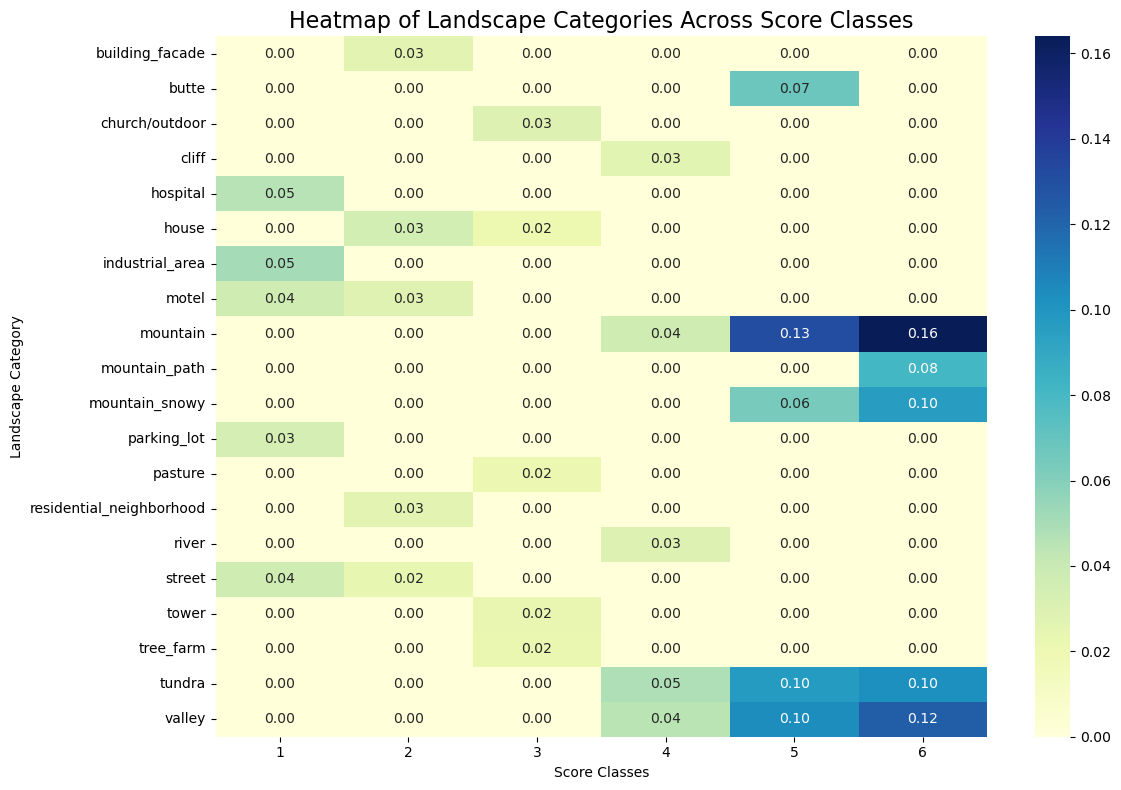

In [27]:
import seaborn as sns
# Prepare the data for the heatmap
heatmap_data = top_5_df.pivot(index='scenery_type', columns='score_bin', values='proportion').fillna(0)

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f")

# Add title and labels
plt.title('Heatmap of Landscape Categories Across Score Classes', fontsize=16)
plt.xlabel('Score Classes')
plt.ylabel('Landscape Category')
plt.tight_layout()

# Show the plot
plt.savefig("/home/ubuntu/landscape-aesthetics/reports/figures/common_landscape_classes_equal_distribution_heatmap_wikidata.jpg")
plt.show()


In [24]:
file_path = '../../data/processed/wikimedia_commons/clean/ns6_clean_00.parquet'
df = pd.read_parquet(file_path)

print("column：", df.columns.tolist())

column： ['ns', 'missing', 'known', 'imagerepository', 'ns6_normalized_title', 'ns6_unnormalized_title', 'date_time', 'object_name', 'commons_metadata_extension', 'categories', 'assessments', 'gps_latitude', 'gps_longitude', 'gps_map_datum', 'image_description', 'credit', 'artist', 'license_short_name', 'usage_terms', 'attribution_required', 'license_url', 'copyrighted', 'restrictions', 'license', 'url', 'image_width', 'image_height', 'mediatype', 'explicit_content', 'metadata_path', 'image_path', 'date_time_original', 'permission', 'attribution', 'query_id', 'country', 'pageid', 'author_count', 'badfile']
